## Imports & constants

In [1]:
import os
from typing import List
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import sys
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import tqdm.notebook as tq
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, 
    TrainingArguments, Trainer, EarlyStoppingCallback, IntervalStrategy
)

from defi_textmine_2025.data.utils import TARGET_COL, INTERIM_DIR, MODELS_DIR

[01:04:15|INFO|config.py:58] PyTorch version 2.3.1 available.
[01:04:15|INFO|config.py:105] TensorFlow version 2.16.2 available.
2024-10-09 01:04:16.086010: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 01:04:16.093977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 01:04:16.104987: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 01:04:16.105004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register fact

In [2]:
RANDOM_SEED = 123  # random reproducibility
np.random.seed(RANDOM_SEED)
# BASE_CHECKPOINT = "bert-base-uncased"
# BASE_CHECKPOINT = "bert-base-multilingual-cased"
BASE_CHECKPOINT = "camembert/camembert-base"
TASK_NAME = "hasrelation"
TASK_TARGET_COL = "label" # hasrelation?
TASK_INPUT_COL = "input_text"

entity_classes = {'TERRORIST_OR_CRIMINAL', 'LASTNAME', 'LENGTH', 'NATURAL_CAUSES_DEATH', 'COLOR', 'STRIKE', 'DRUG_OPERATION', 'HEIGHT', 'INTERGOVERNMENTAL_ORGANISATION', 'TRAFFICKING', 'NON_MILITARY_GOVERNMENT_ORGANISATION', 'TIME_MIN', 'DEMONSTRATION', 'TIME_EXACT', 'FIRE', 'QUANTITY_MIN', 'MATERIEL', 'GATHERING', 'PLACE', 'CRIMINAL_ARREST', 'CBRN_EVENT', 'ECONOMICAL_CRISIS', 'ACCIDENT', 'LONGITUDE', 'BOMBING', 'MATERIAL_REFERENCE', 'WIDTH', 'FIRSTNAME', 'MILITARY_ORGANISATION', 'CIVILIAN', 'QUANTITY_MAX', 'CATEGORY', 'POLITICAL_VIOLENCE', 'EPIDEMIC', 'TIME_MAX', 'TIME_FUZZY', 'NATURAL_EVENT', 'SUICIDE', 'CIVIL_WAR_OUTBREAK', 'POLLUTION', 'ILLEGAL_CIVIL_DEMONSTRATION', 'NATIONALITY', 'GROUP_OF_INDIVIDUALS', 'QUANTITY_FUZZY', 'RIOT', 'WEIGHT', 'THEFT', 'MILITARY', 'NON_GOVERNMENTAL_ORGANISATION', 'LATITUDE', 'COUP_D_ETAT', 'ELECTION', 'HOOLIGANISM_TROUBLEMAKING', 'QUANTITY_EXACT', 'AGITATING_TROUBLE_MAKING'}

generated_data_dir_path = os.path.join(INTERIM_DIR, "reduced_text_w_entity_bracket")
assert os.path.exists(generated_data_dir_path)
train_dir = os.path.join(generated_data_dir_path, "train")
test_dir = os.path.join(generated_data_dir_path, "test")

preprocessed_data_dir = os.path.join(INTERIM_DIR, "one_hot_reduced_text_w_entity_bracket")
labeled_preprocessed_data_dir_path = os.path.join(preprocessed_data_dir,"train")
! mkdir -p {labeled_preprocessed_data_dir_path}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
def get_cat_var_distribution(cat_var: pd.Series) -> pd.DataFrame:
    return pd.concat(
        [cat_var.value_counts(), cat_var.value_counts(normalize=True)], axis=1
    )

## Prepare the datasets for the binary text classification

### Load and process the target

In [4]:
def load_csv(dir_or_file_path: str, index_col=None, sep=',') -> pd.DataFrame:
    if os.path.isdir(dir_or_file_path):
        all_files = glob.glob(os.path.join(dir_or_file_path , "*.csv"))  
    else:
        assert dir_or_file_path.endswith(".csv")
        all_files = [dir_or_file_path]
    assert len(all_files) > 0
    return pd.concat([pd.read_csv(filename, index_col=index_col, header=0, sep=sep) for filename in all_files], axis=0, ignore_index=True)

train_df = load_csv(train_dir, index_col=0).assign(**{
        # TASK_INPUT_COL: lambda df: df[["e1_type", "e2_type", "reduced_text"]].apply(lambda row: ' | '.join(row.values.astype(str)), axis=1),
        TASK_INPUT_COL: lambda df: df["reduced_text"],
        TASK_TARGET_COL: lambda df: 2 + ~pd.isnull(df.relations).astype(int),
    },
)
train_df

,text_index,e1_id,e2_id,e1_type,e2_type,text,relations,reduced_text,input_text,label
0,2576,1,0,FIRE,GATHERING,"Le matin du 10 janvier 2010, Arthur et Jacques...",NaN,"Au milieu de l’[ interview ], un { incendie } ...","Au milieu de l’[ interview ], un { incendie } ...",0
1,2576,0,1,GATHERING,FIRE,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un [ incendie ] ...","Au milieu de l’{ interview }, un [ incendie ] ...",1
2,2576,2,0,CBRN_EVENT,GATHERING,"Le matin du 10 janvier 2010, Arthur et Jacques...",NaN,"Au milieu de l’[ interview ], un incendie est ...","Au milieu de l’[ interview ], un incendie est ...",0
3,2576,0,2,GATHERING,CBRN_EVENT,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un incendie est ...","Au milieu de l’{ interview }, un incendie est ...",1
4,2576,2,1,CBRN_EVENT,FIRE,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’interview, un [ incendie ] est ...","Au milieu de l’interview, un [ incendie ] est ...",1
...,...,...,...,...,...,...,...,...,...,...
122039,41884,11,22,MATERIEL,COLOR,"Le 14 janvier 2014, en pleine Sibérie, dans un...",NaN,"Au moment de sortir de la porte du magasin, Mo...","Au moment de sortir de la porte du magasin, Mo...",0
122040,41884,12,22,MATERIEL,COLOR,"Le 14 janvier 2014, en pleine Sibérie, dans un...",NaN,Au moment de sortir de la { porte } du magasin...,Au moment de sortir de la { porte } du magasin...,0
122041,41884,15,22,MATERIEL,COLOR,"Le 14 janvier 2014, en pleine Sibérie, dans un...",NaN,"Depuis la { fenêtre } des toilettes, monsieur ...","Depuis la { fenêtre } des toilettes, monsieur ...",0
122042,41884,17,22,MATERIEL,COLOR,"Le 14 janvier 2014, en pleine Sibérie, dans un...",['HAS_COLOR'],"Depuis la fenêtre des toilettes, monsieur Bace...","Depuis la fenêtre des toilettes, monsieur Bace...",1


In [5]:
train_df.to_parquet(os.path.join(INTERIM_DIR, "train-entities+reduced_text.parquet"), index=False)

In [6]:
get_cat_var_distribution(train_df[TASK_TARGET_COL])

,count,proportion
label,,
0,95650,0.783734
1,26394,0.216266


### train-validation split

In [7]:
VALIDATION_RATE = 0.2
train_df, val_df = train_test_split(train_df, test_size=VALIDATION_RATE, shuffle=True, random_state=RANDOM_SEED, stratify=train_df[TASK_TARGET_COL])
train_df.shape, val_df.shape

((97635, 10), (24409, 10))

In [8]:
get_cat_var_distribution(train_df[TASK_TARGET_COL])

,count,proportion
label,,
0,76520,0.783735
1,21115,0.216265


In [9]:
get_cat_var_distribution(val_df[TASK_TARGET_COL])

,count,proportion
label,,
0,19130,0.783727
1,5279,0.216273


### Undersampling the majority class

In [10]:
positive_train_df = train_df.query(f"{TASK_TARGET_COL}==1")
positive_train_df.shape

(21115, 10)

In [11]:
negative_train_df = train_df.query(f"{TASK_TARGET_COL}==0")
negative_train_df.shape

(76520, 10)

In [12]:
# balance classes
# train_df = pd.concat([positive_train_df, negative_train_df.sample(positive_train_df.shape[0])], axis=0)
# train_df.shape

## Create the tokenized datasets for model input

### init the tokenizer

In [13]:
# Hyperparameters
tokenizer = AutoTokenizer.from_pretrained(BASE_CHECKPOINT)
task_special_tokens = ["<", ">", "{", "}"] + [
    f"{entity_class}" for entity_class in entity_classes
]
# add special tokens to the tokenizer
num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=True)
num_added_tokens, len(tokenizer)

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(59, 32062)

### init the train-valid datasets from dataframe

In [14]:
train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds = Dataset.from_pandas(val_df, preserve_index=False)
task_datasets = DatasetDict({"train": train_ds, "validation": val_ds})
task_datasets

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label'],
        num_rows: 97635
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label'],
        num_rows: 24409
    })
})

In [15]:
task_datasets["train"][0]

{'text_index': 3653,
 'e1_id': 10,
 'e2_id': 4,
 'e1_type': 'GROUP_OF_INDIVIDUALS',
 'e2_type': 'PLACE',
 'text': "Le 13 mars 2020, une guerre civile a éclaté opposant les citoyens de l'[ Est ] de Londres à ceux du Sud. Les citoyens de l'[ Est ] étaient contre l'installation des citoyens du Sud sur leur territoire. Ils ont utilisé du carburant pour brûler des pneus de voiture et étaient armés de bâtons. Cette guerre a blessé au total 25 personnes. Les victimes étaient des { civils } et des employés de PINS, une société de sécurité. Monsieur Kina Evans était parmi les victimes, il a pu être identifié grâce à sa carte d'identité nationale et son téléphone.",
 'relations': None,
 'reduced_text': "Le 13 mars 2020, une guerre civile a éclaté opposant les citoyens de l'[ Est ] de Londres à ceux du Sud. Les citoyens de l'[ Est ] étaient contre l'installation des citoyens du Sud sur leur territoire. Les victimes étaient des { civils } et des employés de PINS, une société de sécurité.",
 'input

In [16]:
task_datasets["train"][1]

{'text_index': 51462,
 'e1_id': 8,
 'e2_id': 11,
 'e1_type': 'GROUP_OF_INDIVIDUALS',
 'e2_type': 'TIME_EXACT',
 'text': '[ Ce matin ], au Luxembourg, une jeune femme nommée Defne Li, présidente de "l’Ordre des Consommateurs Éclairés", a effectué un communiqué à la télévision. Depuis de nombreuses années, l’association s’est donné pour mission d\'informer les consommateurs afin de leur assurer une alimentation de qualité. Un récent rapport de l\'association a montré que plusieurs marques de glaces et de sorbets de la place étaient contaminées par l\'oxyde d\'éthyle, un pesticide hautement cancérigène qui représente donc un danger pour la santé. Defne Li a invité les { personnes } ayant acheté ces aliments contaminés à se rendre dans les supermarchés avec les tickets d\'achat pour se faire rembourser.',
 'relations': None,
 'reduced_text': '[ Ce matin ], au Luxembourg, une jeune femme nommée Defne Li, présidente de "l’Ordre des Consommateurs Éclairés", a effectué un communiqué à la télév

### Tokenize the datasets

In [17]:
def tokenize_function(example: dict):
    return tokenizer(example[TASK_INPUT_COL], truncation=True)

# We’re using batched=True in our call to map so the function is applied to multiple elements of our dataset at once, and not on each element separately
# This is way faster
# Source https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt
# columns are removed because DataCollatorWithPadding doesn't support any other columns than the ones produced by the tokenizer (or non tensors)
tokenized_datasets = task_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/97635 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/24409 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 97635
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 24409
    })
})

In [18]:
# tokenized_datasets.column_names

In [19]:
type(tokenized_datasets["train"][1]['attention_mask'])

list

### Token numbers distribution

In [20]:
from typing import Any, Dict

def count_tokens(text: str) -> int:
    return len(tokenizer(text)["input_ids"])


def count_token_in_dataset_element(example: Dict[str, Any]) -> Dict[str, int]:
    return {"n_tokens": count_tokens(example[TASK_INPUT_COL])}


tokenized_datasets = tokenized_datasets.map(count_token_in_dataset_element)
tokenized_datasets

Map:   0%|          | 0/97635 [00:00<?, ? examples/s]

Map:   0%|          | 0/24409 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask', 'n_tokens'],
        num_rows: 97635
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask', 'n_tokens'],
        num_rows: 24409
    })
})

In [21]:
split2ntokens_df = pd.DataFrame(
    {
        split_name: pd.Series(
            [e["n_tokens"] for e in tqdm(tokenized_datasets[split_name], split_name)],
            name=f"{split_name}_text_n_tokens",
        )
        for split_name in tokenized_datasets.keys()
    }
)
split2ntokens_df.describe()

validation: 100%|██████████| 24409/24409 [00:01<00:00, 12445.84it/s]


,train,validation
count,97635.000000,24409.000000
mean,63.571701,63.273301
std,29.375446,29.174495
min,10.000000,11.000000
25%,43.000000,42.000000
50%,58.000000,58.000000
75%,78.000000,78.000000
max,299.000000,266.000000


<Axes: >

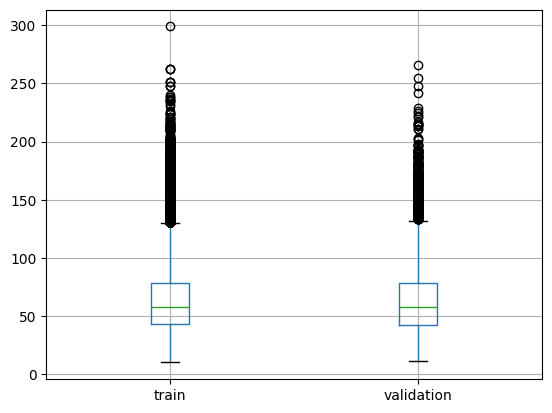

In [22]:
split2ntokens_df.boxplot()

In [23]:
tokenized_datasets["train"].filter(lambda x: x['n_tokens'] > 200)

Filter:   0%|          | 0/97635 [00:00<?, ? examples/s]

Dataset({
    features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask', 'n_tokens'],
    num_rows: 72
})

In [24]:
tokenized_datasets["train"].filter(lambda x: x['n_tokens'] == 19)[0]['input_text']

Filter:   0%|          | 0/97635 [00:00<?, ? examples/s]

"De nombreuses < personnes > ont été calcinées au cours de l'incendie."

In [25]:
# tokenized_datasets["train"].filter(lambda x: x['n_tokens'] > 300)[0]['input_text']

### Test the batch-level padding with a data collator

In [26]:
samples = tokenized_datasets.remove_columns(task_datasets["train"].column_names)["train"][:8]
samples = {k: v for k, v in samples.items()}
[len(x) for x in samples["input_ids"]]

[68, 74, 48, 113, 98, 95, 104, 48]

In [27]:
task_datasets

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label'],
        num_rows: 97635
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label'],
        num_rows: 24409
    })
})

In [28]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 113]),
 'attention_mask': torch.Size([8, 113]),
 'n_tokens': torch.Size([8])}

## Fine-tuning a model with the Trainer API

### Compute the weight of classes to handle imbalance

In [29]:
# Source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
n_examples = train_df.shape[0]
n_classes = train_df[TASK_TARGET_COL].nunique()
def compute_class_weights(lbl_df: pd.DataFrame) -> pd.Series:
    return get_cat_var_distribution(lbl_df[TASK_TARGET_COL]).reset_index(drop=False)["count"].apply(lambda x: (1 / x) * (n_examples / n_classes)).rename("weight")
class_weights_df = compute_class_weights(train_df)
class_weights_df

0    0.637970
1    2.311982
Name: weight, dtype: float64

In [68]:
class_weights = class_weights_df.values.tolist()
class_weights

[0.6379704652378463, 2.311982003315179]

In [33]:
pd.concat([get_cat_var_distribution(train_df[TASK_TARGET_COL]), class_weights_df], axis=1)

,count,proportion,weight
0,76520,0.783735,0.637970
1,21115,0.216265,2.311982


### Init the model

In [34]:
n_classes = train_df[TASK_TARGET_COL].nunique()
print(f"{n_classes=}")
model = AutoModelForSequenceClassification.from_pretrained(BASE_CHECKPOINT, num_labels=n_classes)
model.resize_token_embeddings(len(tokenizer))

n_classes=2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert/camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(32062, 768, padding_idx=0)

In [35]:
model

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32062, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768, padding_idx=0)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

### Init the trainer and launch the training

Source: https://stackoverflow.com/questions/69087044/early-stopping-in-bert-trainer-instances#69087153

1. Use `load_best_model_at_end = True` (EarlyStoppingCallback() requires this to be True).
2. `evaluation_strategy = 'steps'` or IntervalStrategy.STEPS instead of 'epoch'.
3. `eval_steps = 50` (evaluate the metrics after N steps).
4. `metric_for_best_model = 'f1'`

In [72]:
def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average="macro")
    precision = precision_score(y_true=labels, y_pred=pred, average="macro")
    f1 = f1_score(y_true=labels, y_pred=pred, average="macro")    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir=os.path.join(MODELS_DIR, f"{TASK_NAME}-byTrainerAPI-checkpoints"),
    per_device_train_batch_size=20,    
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    eval_strategy=IntervalStrategy.STEPS, # steps
    eval_steps = 1000, # Evaluation and Save happens every 50 steps
    learning_rate=5e-6,
    weight_decay=0.01,
    save_strategy=IntervalStrategy.STEPS,
    save_steps=1000,
    logging_dir=os.path.join(MODELS_DIR, f"{TASK_NAME}-byTrainerAPI-tensorboard"),
    save_total_limit = 2, # Only last 2 models are saved. Older ones are deleted
    push_to_hub=False,
    metric_for_best_model = 'f1',
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="none",
)

class CustomTrainer(Trainer):    
    def compute_loss(self, model, inputs, return_outputs=False):
        """customize the loss to leverage class weights"""
        labels = inputs.get("labels")
        # print(labels)
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # print(logits)
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=4)],
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1000,0.536600,0.501993,0.770863,0.703259,0.771934,0.717036
2000,0.459000,0.444386,0.814044,0.740206,0.801197,0.759187
3000,0.425200,0.405684,0.819943,0.752141,0.827797,0.772701
4000,0.400600,0.380484,0.857307,0.787774,0.836341,0.806736
5000,0.373800,0.386870,0.865787,0.798330,0.841683,0.816021
6000,0.354100,0.374167,0.822320,0.759672,0.846869,0.780308
7000,0.345800,0.354783,0.865132,0.798146,0.856832,0.819974
8000,0.332900,0.341158,0.828998,0.766861,0.856135,0.788405
9000,0.334000,0.337762,0.862674,0.795686,0.859378,0.818469
10000,0.322800,0.332220,0.865541,0.799535,0.867243,0.823257


In [44]:
trainer.callback_handler.callbacks[-2].__dict__

{'early_stopping_patience': 4,
 'early_stopping_threshold': 0.0,
 'early_stopping_patience_counter': 0}

In [48]:
class_weights

tensor([0.6380, 2.3120], device='cuda:0', dtype=torch.float64)

## Evaluate

TODO...

In [ ]:
trainer.state.best_metric

In [ ]:
# After training, access the path of the best checkpoint like this
best_ckpt_path = trainer.state.best_model_checkpoint
best_ckpt_path

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model=best_ckpt_path, device="cuda")

In [ ]:
trainer.evaluate(tokenized_datasets["train"])

In [ ]:
trainer.evaluate(tokenized_datasets["validation"])

In [ ]:
tokenized_datasets["validation"].take(10)

In [ ]:
trainer.predict(tokenized_datasets["validation"].take(10))

In [ ]:
train_df.query("e1_type=='ELECTION' & e2_type=='TIME_EXACT'")[["input_text", "label", "relations"]]

In [ ]:
classifier(train_df.query("e1_type=='ELECTION' & e2_type=='TIME_EXACT'")["input_text"].values.tolist())

In [ ]:
classifier(val_df.query("e1_type=='ELECTION' & e2_type=='TIME_EXACT'")["input_text"].values.tolist())

In [ ]:
val_df[["input_text", "label", "relations"]].iloc[:10]

In [ ]:
classifier(val_ds["input_text"][:10])

In [ ]:
train_df.query("e1_type=='ELECTION' & e2_type=='TIME_EXACT'")[["input_text", "label", "relations"]]

In [ ]:
val_df.query("e1_type=='ELECTION' & e2_type=='TIME_EXACT'")[["input_text", "label", "relations"]]

In [ ]:
train_df.loc[68593][["input_text", "label", "relations"]].values

In [ ]:
train_df.loc[20455][["input_text", "label", "relations"]].values

In [ ]:
val_df.loc[65301][["input_text", "label", "relations"]].values

In [ ]:
val_df.loc[67569][["input_text", "label", "relations"]].values

In [ ]:
val_df.loc[109413][["input_text", "label", "relations"]].values

In [ ]:
val_ds["input_text"][5]

In [ ]:
classifier(val_ds["text"][5])

In [ ]:
val_df[TASK_TARGET_COL].iloc[:10]

In [ ]:
val_ds["input_text"]

In [ ]:
val_ds[0]

In [ ]:
print(samples['input_ids'][2])

In [ ]:
tokenizer.decode(samples['input_ids'][0])

In [ ]:
tokenizer.decode(samples['input_ids'][1])

In [ ]:
tokenizer.decode(samples['input_ids'][2])